In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch

In [3]:
device = ("cuda" if torch.cuda.is_available()else "cpu")
device

'cuda'

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

In [5]:
path2data ="./data/"

In [6]:
if not os.path.exists(path2data):
    os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split = "train", download = True, transform = data_transformer)

100%|██████████| 2.64G/2.64G [01:46<00:00, 24.8MB/s] 


In [7]:
print(train_ds.data.shape)

(5000, 3, 96, 96)


In [8]:
import collections 
y_train = [y for _, y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [9]:
test_ds =datasets.STL10(path2data, split  = "test", download= True, transform =data_transformer)
print(test_ds.data.shape)

(8000, 3, 96, 96)


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

sss= StratifiedShuffleSplit(n_splits  =1, test_size = 0.2, random_state = 67)

indices=list(range(len(test_ds)))

In [11]:
y_test = [y for _,y in test_ds]
for test_index, val_index in sss.split(indices, y_test):
    print(test_index, " ", val_index)
    print(len(val_index), len(test_index))

[ 164 1122 3800 ... 2505 7933 7794]   [1725 1173 6938 ... 6007  310 2033]
1600 6400


In [12]:
from torch.utils.data import Subset

val_ds = Subset(test_ds, val_index)
test_ds= Subset(test_ds, test_index)

In [13]:
y_test = [y for _,y in test_ds]
y_val= [y for _,y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({3: 640, 7: 640, 8: 640, 9: 640, 0: 640, 2: 640, 1: 640, 5: 640, 4: 640, 6: 640})
Counter({9: 160, 5: 160, 1: 160, 0: 160, 4: 160, 6: 160, 2: 160, 3: 160, 7: 160, 8: 160})


In [14]:
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(67)

In [15]:
def show(img,y= None, color  = True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title(y)
        

In [16]:
grid_size =4
rnd_inds = np.random.randint(0,len(train_ds),grid_size)
print(rnd_inds)

[2883 4917 1738 2055]


In [17]:
X_grid = [train_ds[i][0] for i in rnd_inds]
y_grid =[train_ds[i][1] for i in rnd_inds]

X_grid =utils.make_grid(X_grid, nrow =4, padding = 1)

In [18]:
print(X_grid.shape)

torch.Size([3, 98, 389])


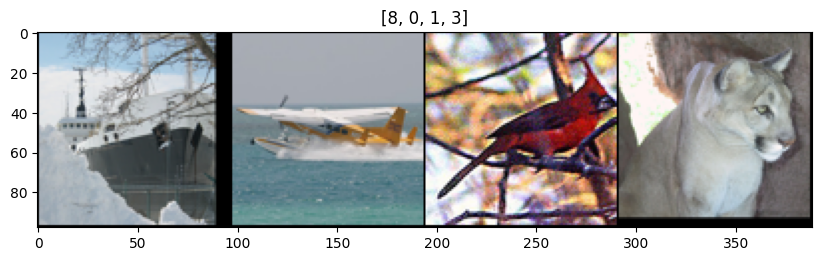

In [19]:
plt.figure(figsize=(10,10))
show(X_grid, y_grid)

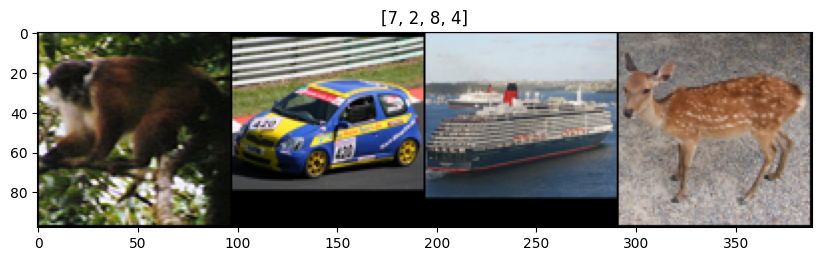

In [20]:
np.random.seed(67)

grid_size= 4

rnd_inds = np.random.randint(0,len(val_ds),grid_size)
X_grid = [val_ds[i][0] for i in rnd_inds]
y_grid = [val_ds[i][1] for i in rnd_inds]

X_grid= utils.make_grid(X_grid, nrow =4, padding= 1)
plt.figure(figsize = (10,10))
show(X_grid, y_grid)

In [21]:
meanRGB = [np.mean(x.numpy(),axis = (1,2)) for x,_ in train_ds]
stdRGB = [np.std(x.numpy(),axis = (1,2)) for x,_ in train_ds]

meanR =np.mean([s[0] for s in meanRGB])
meanG =np.mean([s[1] for s in meanRGB])
meanB =np.mean([s[2] for s in meanRGB])

stdR =np.mean([s[0] for s in stdRGB])
stdG =np.mean([s[1] for s in stdRGB])
stdB =np.mean([s[2] for s in stdRGB])
print(meanR,meanG, meanB)
print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [22]:
train_transoform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize([meanR,meanG,meanB], [stdR, stdG, stdB])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR,stdG, stdB])
])

In [23]:
train_ds.transform = train_transoform
test_ds = datasets.STL10(path2data, download =True, split = "test", transform = test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9929461..2.6500857].


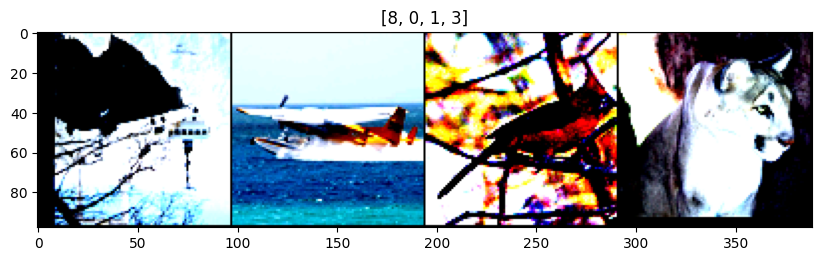

In [24]:
np.random.seed(67)
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
X_grid = [train_ds[i][0] for i in rnd_inds]
y_grid =[train_ds[i][1] for   i in rnd_inds ]

X_grid = utils.make_grid(X_grid, nrow =4, padding =1)
plt.figure(figsize =  (10,10))
show(X_grid, y_grid)

In [25]:
y_test = [y for _,y in test_ds]
for test_index, val_index in sss.split(indices, y_test):
    print(test_index, " ", val_index)
    print(len(val_index), len(test_index))

from torch.utils.data import Subset

val_ds = Subset(test_ds, val_index)
test_ds= Subset(test_ds, test_index)

y_test = [y for _,y in test_ds]
y_val= [y for _,y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

[ 164 1122 3800 ... 2505 7933 7794]   [1725 1173 6938 ... 6007  310 2033]
1600 6400
Counter({3: 640, 7: 640, 8: 640, 9: 640, 0: 640, 2: 640, 1: 640, 5: 640, 4: 640, 6: 640})
Counter({9: 160, 5: 160, 1: 160, 0: 160, 4: 160, 6: 160, 2: 160, 3: 160, 7: 160, 8: 160})


In [26]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
val_dl = DataLoader(val_ds, batch_size =64, shuffle= False)
test_dl = DataLoader(test_ds, batch_size =64, shuffle =False)

In [27]:
for x,y  in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])


In [28]:
for x,y in test_dl:
    print(x.shape)
    print(y)
    break

torch.Size([64, 3, 96, 96])
tensor([3, 7, 3, 8, 9, 9, 0, 8, 2, 2, 7, 3, 7, 1, 5, 5, 9, 7, 5, 1, 5, 5, 5, 1,
        4, 3, 6, 1, 0, 6, 7, 7, 9, 4, 6, 0, 2, 4, 6, 9, 9, 9, 5, 4, 6, 9, 6, 4,
        0, 4, 9, 8, 4, 6, 2, 0, 3, 1, 9, 3, 6, 3, 5, 4])


In [29]:
from torchvision import models
import torch

model_resnet18= models.resnet18(pretrained = False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
device

'cuda'

In [32]:
import torch.nn as nn
num_classes =10

num_ftrs =model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)
model_resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
w = model_resnet18.conv1.weight.data.cpu()


min_w=torch.min(w)
w1 = (-1/(2*min_w))*w + 0.5
print(torch.min(w1).item(),torch.max(w1).item())

0.0 1.1288695335388184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1288695].


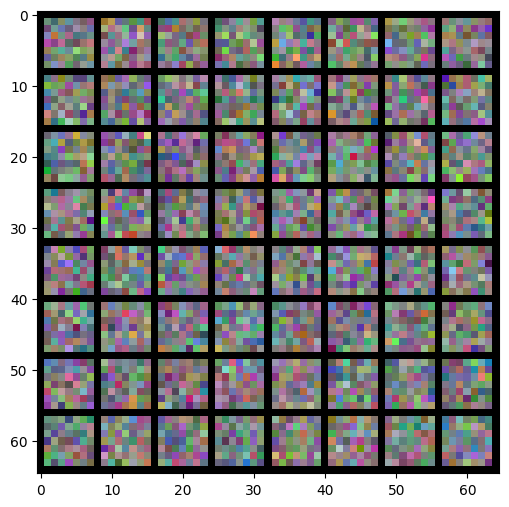

In [34]:
grid_size =len(w1)
X_grid = [w1[i] for i in range(grid_size)]
X_grid = utils.make_grid(X_grid, nrow =8, padding = 1)
plt.figure(figsize = (6,6))
show(X_grid)

In [35]:
resnet18_pretrained = models.resnet18(pretrained =True)
num_classes = 10
resnet18_pretrained.fc = nn.Linear(resnet18_pretrained.fc.in_features, num_classes)
resnet18_pretrained.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

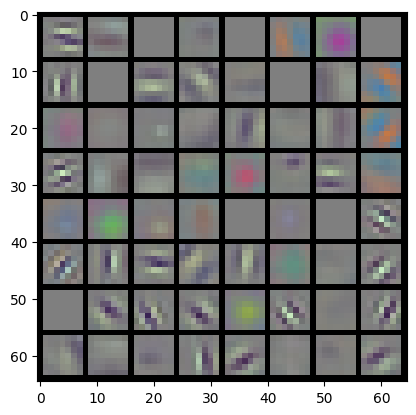

In [36]:
w = resnet18_pretrained.conv1.weight.data.cpu()

w1 = torch.min(w)
w1 = ((-1/2*w1))*w + 0.5
grid_size = len(w1)
X_grid = [w1[i] for  i in range(grid_size)]
X_grid = utils.make_grid(X_grid, nrow =8 , padding = 1)
show(X_grid)

In [37]:
loss_func =nn.CrossEntropyLoss(reduction = "sum")

In [38]:
from torch import optim

opt = optim.Adam(model_resnet18.parameters(), lr = 1e-4)
def get_lr(opt):
    for p_g in opt.param_groups:
        return p_g["lr"]

current_lr = get_lr(opt)
print(current_lr)

0.0001


In [39]:
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_scheduler = CosineAnnealingLR(opt, T_max =2, eta_min =1e-5)
for  i in range(10):
    lr_scheduler.step()
    print(i, " ", get_lr(opt))

0   5.5e-05
1   1e-05
2   5.4999999999999995e-05
3   0.0001
4   5.500000000000001e-05
5   1e-05
6   5.4999999999999995e-05
7   0.00010000000000000003
8   5.5000000000000036e-05
9   1e-05


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


In [40]:
def metrics_batch(output,target):
    preds = output.argmax(dim = 1, keepdim = True)
    correct = preds.eq(target.view_as(preds)).sum().item()
    return correct

In [41]:
def loss_batch(loss_func, output, target, opt= None):
    loss=loss_func(output,target)
    metric_b =metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [42]:
def loss_epoch(model, loss_func, dl, sanity_check = False, opt = None):
    running_loss = 0.0
    running_metric = 0.0
    len_data= len(dl)
    for xb, yb in dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output =model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt )
        running_loss+= loss_b
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
    loss = running_loss/float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric

In [43]:
def train_val(model,params):
    num_epochs = params["num_epochs"]
    loss_func =params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler =params["lr_scheduler"]
    path2weights = params["path2weights"]

    loss_history = {
        "train": [],
        "val": []
    }
    metric_history = {
        "train": [],
        "val": []
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss =float("inf")
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs- 1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model , loss_func, train_dl, sanity_check, opt)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        model.eval()
        with torch.no_grad():
            val_loss,val_metric =loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history["val"].append(val_loss)
            metric_history["val"].append(val_metric)
            if val_loss< best_loss:
                best_loss = val_loss
                best_model_wts =copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path2weights)
                print("succsess")

            lr_scheduler.step()
            print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f"%(train_loss,val_loss,100*val_metric))
            print("-"*10)
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [47]:
import copy
loss_func = nn.CrossEntropyLoss(reduction ="sum")
opt = torch.optim.Adam(model_resnet18.parameters(), lr = 1e-4)
lr_scheduler = CosineAnnealingLR(opt, T_max= 5, eta_min = 1e-6)
os.makedirs("./models", exist_ok=True)
params_train={
"num_epochs": 10,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": val_dl,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": "./models/resnet18.pt",
}
model_resnet18,loss_hist,metric_hist=train_val(model_resnet18,params_train)

Epoch 0/9, current lr=0.0001
succsess
train loss: 13.921680, dev loss: 108.994923, accuracy: 3184.00
----------
Epoch 1/9, current lr=9.05463412215599e-05
succsess
train loss: 12.838969, dev loss: 95.576351, accuracy: 3432.00
----------
Epoch 2/9, current lr=6.57963412215599e-05
train loss: 9.777790, dev loss: 99.971616, accuracy: 3448.00
----------
Epoch 3/9, current lr=3.52036587784401e-05
succsess
train loss: 7.069296, dev loss: 93.791837, accuracy: 3560.00
----------
Epoch 4/9, current lr=1.0453658778440105e-05
succsess
train loss: 5.309527, dev loss: 89.717794, accuracy: 3612.00
----------
Epoch 5/9, current lr=1e-06
succsess
train loss: 4.223618, dev loss: 89.192803, accuracy: 3640.00
----------
Epoch 6/9, current lr=1.0453658778440102e-05
train loss: 4.039819, dev loss: 89.822650, accuracy: 3668.00
----------
Epoch 7/9, current lr=3.520365877844011e-05
train loss: 4.421956, dev loss: 100.693856, accuracy: 3544.00
----------
Epoch 8/9, current lr=6.579634122155992e-05
train loss:

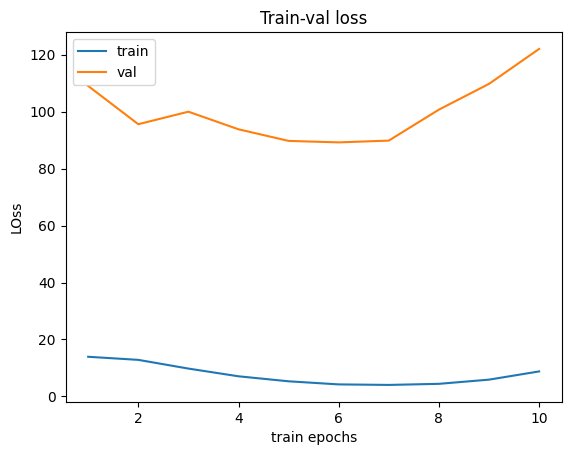

In [49]:
num_epochs = params_train["num_epochs"]
plt.title("Train-val loss")
plt.plot(range(1, num_epochs +1 ), loss_hist["train"], label = "train")
plt.plot(range(1,num_epochs+1), loss_hist["val"], label = "val")
plt.ylabel("LOss")
plt.xlabel("train epochs")
plt.legend()
plt.show()

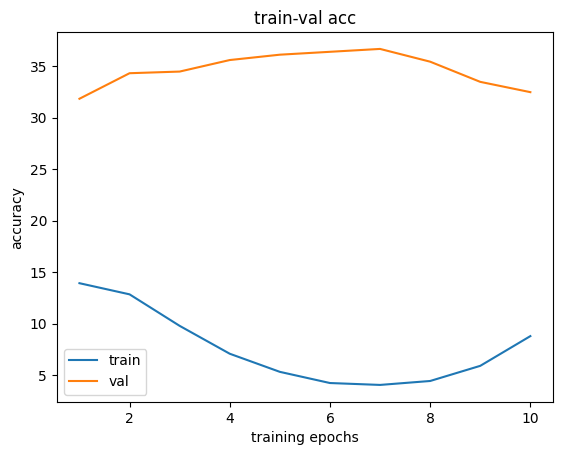

In [50]:
plt.title("train-val acc")
plt.plot(range(1,num_epochs+1), loss_hist["train"], label = "train")
plt.plot(range(1,num_epochs+1), metric_hist["val"],label = "val")
plt.ylabel("accuracy")
plt.xlabel("training epochs")
plt.legend()
plt.show()

In [53]:
import copy

loss_func =nn.CrossEntropyLoss(reduction = "sum")
opt = torch.optim.Adam(resnet18_pretrained.parameters(), lr = 1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max =5, eta_min =1e-6)

In [54]:
params_train={
"num_epochs": 10,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": val_dl,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": "./models/resnet18_pretrained.pt",
}
resnet18_pretrained,loss_hist,metric_hist=train_val(resnet18_pretrained,params_train)

Epoch 0/9, current lr=0.0001
succsess
train loss: 28.748747, dev loss: 30.461606, accuracy: 5336.00
----------
Epoch 1/9, current lr=9.05463412215599e-05
succsess
train loss: 13.672653, dev loss: 27.160897, accuracy: 5404.00
----------
Epoch 2/9, current lr=6.57963412215599e-05
succsess
train loss: 9.517359, dev loss: 24.119710, accuracy: 5556.00
----------
Epoch 3/9, current lr=3.52036587784401e-05
succsess
train loss: 6.418166, dev loss: 22.003261, accuracy: 5624.00
----------
Epoch 4/9, current lr=1.0453658778440105e-05
succsess
train loss: 5.141550, dev loss: 21.451978, accuracy: 5636.00
----------
Epoch 5/9, current lr=1e-06
train loss: 4.662392, dev loss: 21.735300, accuracy: 5660.00
----------
Epoch 6/9, current lr=1.0453658778440102e-05
succsess
train loss: 4.325440, dev loss: 21.397347, accuracy: 5640.00
----------
Epoch 7/9, current lr=3.520365877844011e-05
succsess
train loss: 4.250616, dev loss: 21.352142, accuracy: 5724.00
----------
Epoch 8/9, current lr=6.579634122155992

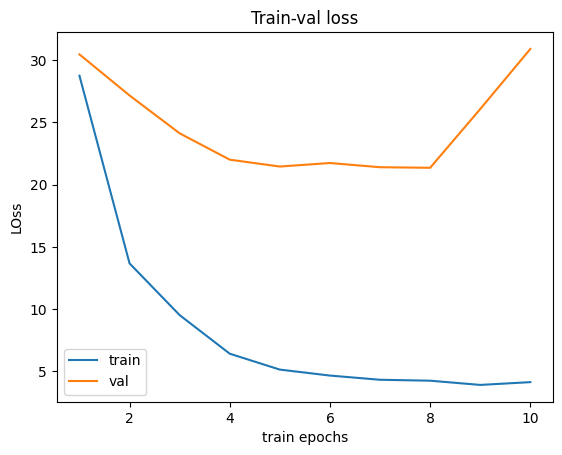

In [56]:
num_epochs = params_train["num_epochs"]
plt.title("Train-val loss")
plt.plot(range(1, num_epochs +1 ), loss_hist["train"], label = "train")
plt.plot(range(1,num_epochs+1), loss_hist["val"], label = "val")
plt.ylabel("LOss")
plt.xlabel("train epochs")
plt.legend()
plt.show()

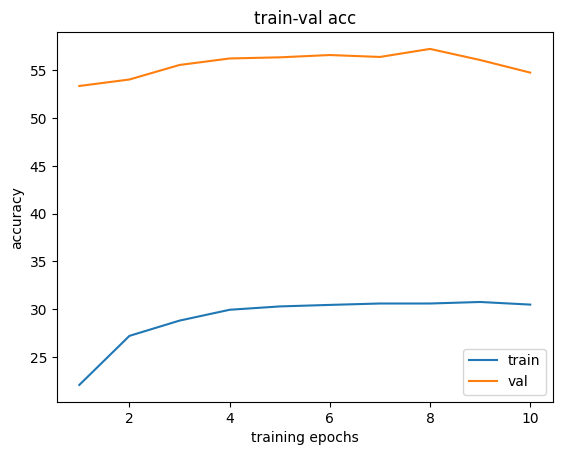

In [57]:
plt.title("train-val acc")
plt.plot(range(1,num_epochs+1), metric_hist["train"], label = "train")
plt.plot(range(1,num_epochs+1), metric_hist["val"],label = "val")
plt.ylabel("accuracy")
plt.xlabel("training epochs")
plt.legend()
plt.show()

In [58]:
from torch import nn
from torchvision import models

model_resnet18= models.resnet18(pretrained = False)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 10)

In [60]:
path2weights= "./models/resnet18_pretrained.pt"
model_resnet18.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [61]:
model_resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model_resnet18 = model_resnet18.to(device)

In [64]:
def deploy_model(model, dataset, device, num_classes = 10, sanity_check = False):
    len_data = len(dataset)
    y_out =torch.zeros(len_data, 10)
    y_gt = np.zeros((len_data), dtype  = "uint8")
    model = model.to(device)
    elapsed_time = []

In [65]:

with torch.no_grad():
    for i in range(len_data):
        x, y = dataset[i]
        y_gt[i] = y
        start = time.time()
        yy = model(x.unsqueeze(0).to(device))
        y_out[i]  = torch.softmax(yy, dim = 1)
        elapsed = time.time() - start
        elapsed_time.append(elapsed)
        if sanity_check is True:
            break

NameError: name 'len_data' is not defined